In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import fiona
import collections
import matplotlib.pyplot as plt
import pyproj
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio import features
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date, timedelta
import geopandas
import os
from shapely import geometry
import numpy as np
import utilities
import pandas as pd
import shutil
import glob
pd.set_option('display.max_columns', None)
import time
import zipfile
import geopandas as gpd
import shapely
import geopandas as gpd
from shapely.geometry import MultiPoint, Polygon

In [3]:
# 18-21 Jul 2019
start_date = date.today() - timedelta(15)
end_date = date.today()

In [4]:
path = "/home/primity/terras/bulk/"
dest = "/home/primity/terras/bulk_crops/"

In [5]:
freguesias_shapes=fiona.open("gadm36_PRT_shp/gadm36_PRT_3.shp")
concelhos_shapes = fiona.open("gadm36_PRT_shp/gadm36_PRT_2.shp")

for shp in freguesias_shapes:
    #print(shp['properties']['NAME_3'])
    if shp['properties']['NAME_3']=='Cardigos' :
        cardigos_shp = shp

for shp in concelhos_shapes:
    if shp['properties']['NAME_2'] =='Mação':
        macao_shp = shp
        
macao_outer_square = utilities.outer_square_points(macao_shp['geometry']['coordinates'][0])

In [6]:
os.makedirs(path, exist_ok=True)
os.makedirs(dest, exist_ok=True)


#get products list from this day
api = SentinelAPI('fernandeslouro', 'copernicospw', 'https://scihub.copernicus.eu/dhus')
products = api.query(macao_outer_square,
                     date=(date.today() - timedelta(15), date.today()),
                     platformname='Sentinel-2',
                     cloudcoverpercentage=(0, 30))
products_df = api.to_dataframe(products)

products_df['footprint'] = geopandas.GeoSeries.from_wkt(products_df['footprint'])
products_df = gpd.GeoDataFrame(products_df, geometry='footprint')

products_df['fully_contained'] = products_df.apply(lambda row: row.footprint.contains(Polygon(macao_shp['geometry']['coordinates'][0])), axis=1)
products_df['centroid_distances'] = products_df.apply(lambda row: row.footprint.centroid.distance(macao_outer_square.centroid), axis=1)
products_df['intersection_area'] = products_df.apply(lambda row: 
                                                     Polygon(macao_shp['geometry']['coordinates'][0]).intersection(row.footprint).area/Polygon(macao_shp['geometry']['coordinates'][0]).area, axis=1)

print(f"{len(products)} available products")
# download them all
to_download = products_df[products_df.intersection_area == max(products_df.intersection_area)].sample(1)
to_download = utilities.single_row_dataframe_to_dict(to_download)

utilities.download_no_fail(to_download['uuid'], path, 'fernandeslouro', 'copernicospw', 'https://scihub.copernicus.eu/dhus')

with zipfile.ZipFile(os.path.join(path, to_download['title']+'.zip'), 'r') as zip_ref:
    zip_ref.extractall(path)

os.remove(os.path.join(path, to_download['title']+'.zip'))

# copy jp2 to dest
utilities.subfolders_copy(os.path.join(path, to_download['title'] + '.SAFE'), dest)

# save cropped jp2 with same name 
for i in utilities.listdir_nohidden(dest):
    with rasterio.open(os.path.join(dest, i)) as src:
        out_image, out_transform = rasterio.mask.mask(src, utilities.transform_shapefile(macao_shp), crop=True, nodata=0, all_touched=True)
        out_meta = src.meta.copy() 
        
    with rasterio.open(os.path.join(dest, i)[:-4]+'.png','w',
                       driver='PNG',
                       height=out_image.shape[1],
                       width=out_image.shape[2],
                       dtype=rasterio.uint8,
                       count=out_image.shape[0],
                       compress='lzw') as dst:
        dst.write(np.array(out_image, dtype='uint8'))

for f in utilities.listdir_nohidden(dest):
    if '.jp2' in f and not f.startswith('.'):
        os.remove(os.path.join(dest, f))

#for f in glob.glob(os.path.join(path, to_download['title'])):
#    os.remove(f)
 

11 available products
Trying to download 300f1a09-222e-454a-aa71-fec8abd385a4


Downloading: 100%|██████████| 1.20G/1.20G [12:27<00:00, 1.51MB/s]
MD5 checksumming: 100%|██████████| 1.20G/1.20G [00:01<00:00, 816MB/s]
/home/primity/.miniconda3/envs/eruditio/lib/python3.9/site-packages/rasterio/__init__.py:217: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = writer(path, mode, driver=driver,


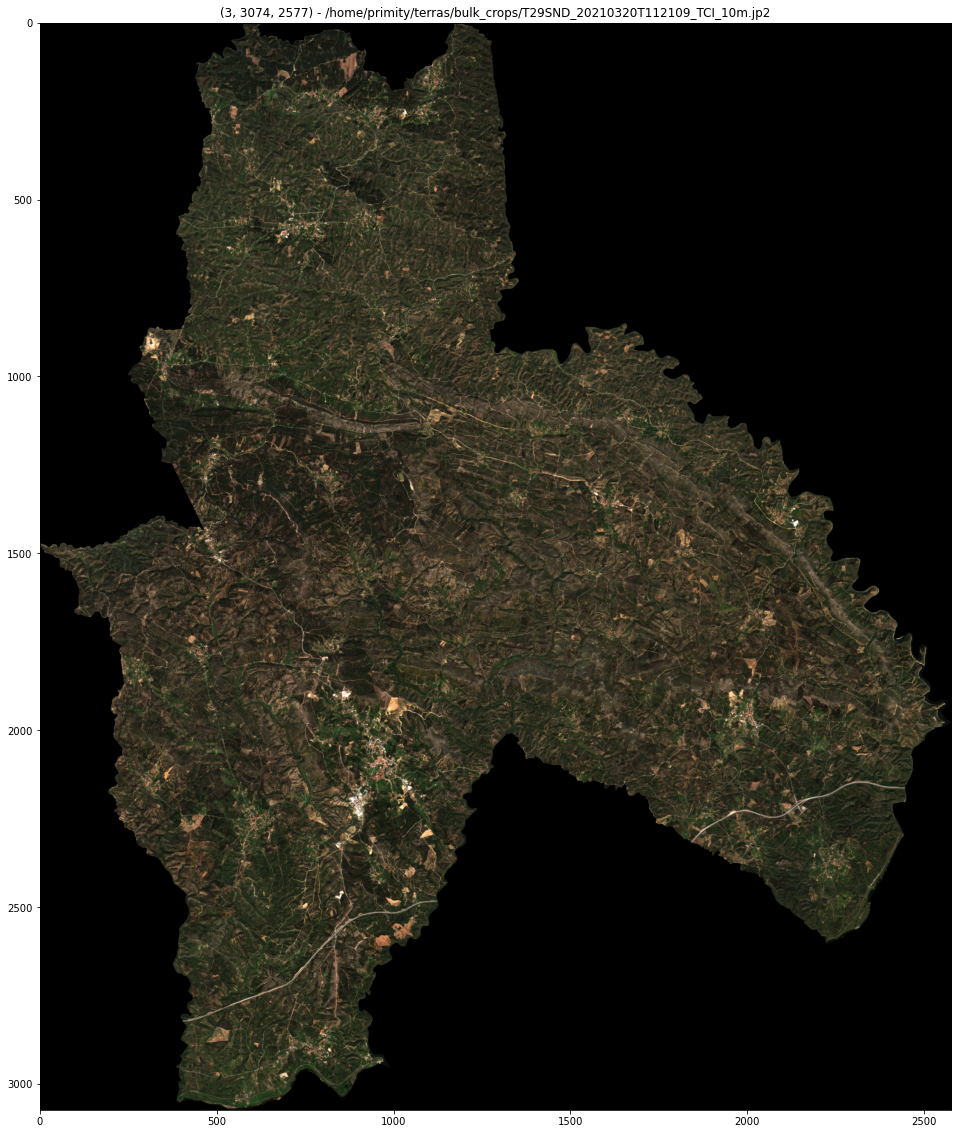

<AxesSubplot:title={'center':'(3, 3074, 2577) - /home/primity/terras/bulk_crops/T29SND_20210320T112109_TCI_10m.jp2'}>

In [7]:
plt.figure(figsize=(20,20))
plt.title(f'{np.array(out_image).shape} - {i}')
#plt.save(i)
out_image = (out_image-out_image.min())/(out_image.max()-out_image.min())
show(out_image)
